In [248]:
from src.Distributions import *
from collections import Counter
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import matplotlib.lines as mlines
plt.style.use('properties.mplstyle')

In [249]:
alpha_a_v = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
alpha_g_f = 2.0

alpha_a_f = 2.0
alpha_g_v = [1.0, 2.0, 3.0, 4.0, 5.0]

N = 10**5
dim = [1,2,3,4]

In [10]:
import os
import glob
import pandas as pd
import numpy as np
import re
from multiprocessing import Pool

def process_distance_file(args):
    idx, file = args
    try:
        degrees = np.random.randint(0, 10, size=10**5)  # Simulação
        return idx, degrees, os.path.basename(file)
    except Exception as e:
        print(f"Erro ao processar {file}: {e}")
        return None

def process_all_degree_files(base_path):
    """Percorre toda a estrutura de pastas e processa os arquivos de grau."""
    pattern = os.path.join(base_path, "N_*", "dim_*", "alpha_a_*_alpha_g*", "gml")
    all_gml_folders = sorted(glob.glob(pattern))

    if not all_gml_folders:
        print("Nenhuma pasta com arquivos .gml encontrada.")
        return

    for gml_folder in all_gml_folders:
        output_dir = os.path.dirname(gml_folder)
        path_parts = output_dir.split(os.sep)

        try:
            N = int(path_parts[-3].split("_")[1])
            dim = int(path_parts[-2].split("_")[1])

            # 🔍 Corrigir extração de alpha_a e alpha_g com regex
            match = re.match(r'alpha_a_([0-9.]+)_alpha_g_([0-9.]+)', path_parts[-1])
            if not match:
                raise ValueError(f"Formato inesperado de pasta: {path_parts[-1]}")
            alpha_a = float(match.group(1))
            alpha_g = float(match.group(2))

            # Garantir 2 casas decimais
            alpha_a_str = f"{alpha_a:.2f}"
            alpha_g_str = f"{alpha_g:.2f}"

        except Exception as e:
            print(f"Erro ao extrair parâmetros da pasta: {output_dir} — {e}")
            continue

        print(f"Processando: N={N}, dim={dim}, alpha_a={alpha_a_str}, alpha_g={alpha_g_str}")

        # Arquivos da pasta
        all_files = sorted(glob.glob(os.path.join(gml_folder, "*.gml.gz")))

        if not all_files:
            print(f"Pasta vazia: {gml_folder}")
            continue

        n_files = len(all_files)
        n_lines = 10**5

        # Caminhos dos arquivos de saída
        degree_npy_path = os.path.join(base_path, f"N_{N}/dim_{dim}/alpha_a_{alpha_a_str}_alpha_g_{alpha_g_str}/degree.npy")
        filenames_csv_path = os.path.join(base_path, f"N_{N}/dim_{dim}/alpha_a_{alpha_a_str}_alpha_g_{alpha_g_str}/filenames_degree.csv")

        # Verificar arquivos já processados
        if os.path.exists(filenames_csv_path):
            df_existing = pd.read_csv(filenames_csv_path)
            processed_files = set(df_existing["filenames"].tolist())
        else:
            df_existing = pd.DataFrame(columns=["filenames"])
            processed_files = set()

        # Filtrar os não processados
        new_files = [file for file in all_files if os.path.basename(file) not in processed_files]

        if not new_files:
            print("Todos os arquivos já foram processados. Pulando...")
            continue

        print(f"  → Processando {len(new_files)} novos arquivos...")

        with Pool() as pool:
            results = pool.map(process_distance_file, enumerate(new_files))

        results = [res for res in results if res is not None]

        new_filenames = []
        new_data = np.empty((n_lines, len(results)), dtype=np.int32)

        for i, (idx, degrees, filename) in enumerate(results):
            new_data[:, i] = degrees
            new_filenames.append(filename)

        # Concatenar com dados existentes (se houver)
        if os.path.exists(degree_npy_path):
            existing_data = np.load(degree_npy_path)
            updated_data = np.hstack((existing_data, new_data))
        else:
            updated_data = new_data

        np.save(degree_npy_path, updated_data)

        # Atualizar CSV
        df_new = pd.DataFrame({"filenames": new_filenames})
        df_updated = pd.concat([df_existing, df_new], ignore_index=True)
        df_updated.to_csv(filenames_csv_path, index=False)

        print(f"  ✔ Dados salvos em: {os.path.dirname(degree_npy_path)}\n")

# Exemplo de uso:
process_all_degree_files("../../data/")


Processando: N=5000, dim=1, alpha_a=3.00, alpha_g=2.00
Pasta vazia: ../../data/N_5000/dim_1/alpha_a_3.00_alpha_g_2.00/gml
Processando: N=5000, dim=2, alpha_a=10.00, alpha_g=2.00
Pasta vazia: ../../data/N_5000/dim_2/alpha_a_10.00_alpha_g_2.00/gml
Processando: N=5000, dim=2, alpha_a=7.00, alpha_g=2.00
Pasta vazia: ../../data/N_5000/dim_2/alpha_a_7.00_alpha_g_2.00/gml
Processando: N=5000, dim=2, alpha_a=8.00, alpha_g=2.00
Pasta vazia: ../../data/N_5000/dim_2/alpha_a_8.00_alpha_g_2.00/gml
Processando: N=5000, dim=3, alpha_a=10.00, alpha_g=2.00
Pasta vazia: ../../data/N_5000/dim_3/alpha_a_10.00_alpha_g_2.00/gml
Processando: N=5000, dim=3, alpha_a=12.00, alpha_g=2.00
Pasta vazia: ../../data/N_5000/dim_3/alpha_a_12.00_alpha_g_2.00/gml
Processando: N=5000, dim=3, alpha_a=14.00, alpha_g=2.00
Pasta vazia: ../../data/N_5000/dim_3/alpha_a_14.00_alpha_g_2.00/gml
Processando: N=5000, dim=3, alpha_a=15.00, alpha_g=2.00
Pasta vazia: ../../data/N_5000/dim_3/alpha_a_15.00_alpha_g_2.00/gml
Processando: N

In [3]:
# Generate .npy with all degree and distances values from gml.gz files
for d in dim:
    for aa in alpha_a_v:
        print(f"N = {N}, dim = {d}, alpha_a = {aa}, alpha_g = {alpha_g_f}")
        degree_file(N, d, aa, alpha_g_f)
        distance_file(N, d, aa, alpha_g_f)
    print("-----------------")
    for ag in alpha_g_v:
        print(f"N = {N}, dim = {d}, alpha_a = {alpha_a_f}, alpha_g = {ag}")
        degree_file(N, d, alpha_a_f, ag)
        distance_file(N, d, alpha_a_f, ag)

N = 100000, dim = 1, alpha_a = 0.0, alpha_g = 2.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 1.0, alpha_g = 2.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 2.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 3.0, alpha_g = 2.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 4.0, alpha_g = 2.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 5.0, alpha_g = 2.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 6.0, alpha_g = 2.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 7.0, alpha_g = 2.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 8.0, alpha_g = 2.0
Folder empty
Folder empty
-----------------
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 1.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 2.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 3.0
Folder empty
Folder empty
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 4.0
Folder empty
Folder 

In [88]:
# Delete all gml files after processing distances and degrees
folder = "../../data"
delete_files_in_gml_folders(folder)

Removendo arquivos dentro da pasta: ../../data/N_5000/dim_1/alpha_a_3.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_3/alpha_a_14.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_3/alpha_a_15.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_3/alpha_a_10.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_3/alpha_a_12.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_4/alpha_a_14.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_4/alpha_a_15.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_4/alpha_a_10.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_4/alpha_a_13.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_4/alpha_a_12.0_alpha_g_2.0/gml
Removendo arquivos dentro da pasta: ../../data/N_5000/dim_2/alpha_a_8.0_alpha_g_2.0/gml
Removendo arquivos dent

In [3]:
# Generate .npy with all degree values from gml.gz files
bin_count = 80
for d in dim:
    for aa in alpha_a_v:
        # Generate log_binning file to distances and degree
        print(f"N = {N}, dim = {d}, alpha_a = {aa}, alpha_g = {alpha_g_f}")
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{aa:.2f}_alpha_g_{alpha_g_f:.2f}/distances.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=aa, alpha_g=alpha_g_f, propertie="distances")
        
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{aa:.2f}_alpha_g_{alpha_g_f:.2f}/degree.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=aa, alpha_g=alpha_g_f, propertie="degree")

        # Generate linear binning to degree
        distribution(dados_flat, save=True, N=N, dim=d, alpha_a=aa, alpha_g=alpha_g_f, propertie="degree")
    
    print("-----------------")
    for ag in alpha_g_v:
        # Generate log_binning file to distances and degree
        print(f"N = {N}, dim = {d}, alpha_a = {alpha_a_f}, alpha_g = {ag}")
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_a_f:.2f}_alpha_g_{ag:.2f}/distances.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=alpha_a_f, alpha_g=ag, propertie="distances")
        
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_a_f:.2f}_alpha_g_{ag:.2f}/degree.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=alpha_a_f, alpha_g=ag, propertie="degree")

        # Generate linear binning to degree
        distribution(dados_flat, save=True, N=N, dim=d, alpha_a=alpha_a_f, alpha_g=ag, propertie="degree")

N = 100000, dim = 1, alpha_a = 0.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_0.00_alpha_g_2.00/distances_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_0.00_alpha_g_2.00/degree_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_0.00_alpha_g_2.00/degree_distribution_linear.csv
N = 100000, dim = 1, alpha_a = 1.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_1.00_alpha_g_2.00/distances_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_1.00_alpha_g_2.00/degree_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_1.00_alpha_g_2.00/degree_distribution_linear.csv
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.00_alpha_g_2.00/distances_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.00_alpha_g_2.00/degree_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.00_alp

In [250]:
alpha_a_v = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
alpha_g_f = 2.0

alpha_a_f = 2.0
alpha_g_v = [1.0, 2.0, 3.0, 4.0, 5.0]

k_1d_g, pk_1d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_2d_g, pk_2d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_3d_g, pk_3d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_4d_g, pk_4d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]

k_1d_a, pk_1d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_2d_a, pk_2d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_3d_a, pk_3d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_4d_a, pk_4d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]

In [251]:
for i in range(len(alpha_g_v)):
    df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_linear.csv", delimiter=' ')
    df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_linear.csv", delimiter=' ')
    df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_linear.csv", delimiter=' ')
    df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_linear.csv", delimiter=' ')
    
    k_1d_g[i], pk_1d_g[i] = df_1d["k"], df_1d["pk"]
    k_2d_g[i], pk_2d_g[i] = df_2d["k"], df_2d["pk"]
    k_3d_g[i], pk_3d_g[i] = df_3d["k"], df_3d["pk"]
    k_4d_g[i], pk_4d_g[i] = df_4d["k"], df_4d["pk"]
alpha_a_v = [0.0, 1.0, 2.0, 4.0, 6.0, 8.0]
for i in range(len(alpha_a_v)):
        df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_linear.csv", delimiter=' ')
        df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_linear.csv", delimiter=' ')
        df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_linear.csv", delimiter=' ')
        df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_linear.csv", delimiter=' ')

        k_1d_a[i], pk_1d_a[i] = df_1d["k"], df_1d["pk"]
        k_2d_a[i], pk_2d_a[i] = df_2d["k"], df_2d["pk"]
        k_3d_a[i], pk_3d_a[i] = df_3d["k"], df_3d["pk"]
        k_4d_a[i], pk_4d_a[i] = df_4d["k"], df_4d["pk"]

In [252]:
k_1d_g_log, pk_1d_g_log = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_2d_g_log, pk_2d_g_log = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_3d_g_log, pk_3d_g_log = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_4d_g_log, pk_4d_g_log = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]

k_1d_a_log, pk_1d_a_log = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_2d_a_log, pk_2d_a_log = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_3d_a_log, pk_3d_a_log = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_4d_a_log, pk_4d_a_log = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]

In [253]:
for i in range(len(alpha_g_v)):
    df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_log.csv", delimiter=' ')
    df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_log.csv", delimiter=' ')
    df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_log.csv", delimiter=' ')
    df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_log.csv", delimiter=' ')
    
    k_1d_g_log[i], pk_1d_g_log[i] = df_1d["k"], df_1d["pk"]
    k_2d_g_log[i], pk_2d_g_log[i] = df_2d["k"], df_2d["pk"]
    k_3d_g_log[i], pk_3d_g_log[i] = df_3d["k"], df_3d["pk"]
    k_4d_g_log[i], pk_4d_g_log[i] = df_4d["k"], df_4d["pk"]

for i in range(len(alpha_a_v)):
    df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_log.csv", delimiter=' ')
    df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_log.csv", delimiter=' ')
    df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_a_f:.2f}/degree_distribution_log.csv", delimiter=' ')
    df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_a_f:.2f}/degree_distribution_log.csv", delimiter=' ')
    
    k_1d_a_log[i], pk_1d_a_log[i] = df_1d["k"], df_1d["pk"]
    k_2d_a_log[i], pk_2d_a_log[i] = df_2d["k"], df_2d["pk"]
    k_3d_a_log[i], pk_3d_a_log[i] = df_3d["k"], df_3d["pk"]
    k_4d_a_log[i], pk_4d_a_log[i] = df_4d["k"], df_4d["pk"]


In [7]:
# # The adjustment will be done only in the pk region in the interval [10⁻⁶, 1], filtering pk values ​​in this interval
# k_filtered = []
# pk_filtered = []
# threshold = 1e-6  # Definição do limite mínimo

# for k_sublist, pk_sublist in zip(k_1d_g, pk_1d_g):
#     # Filtra os valores mantendo a relação 1:1
#     filtered_pairs = [(ki, pki) for ki, pki in zip(k_sublist, pk_sublist) if pki >= threshold]
    
#     # Separa novamente em listas individuais
#     if filtered_pairs:
#         k_filtered.append([ki for ki, pki in filtered_pairs])
#         pk_filtered.append([pki for ki, pki in filtered_pairs])
#     else:
#         k_filtered.append([])  # Mantém a estrutura original
#         pk_filtered.append([])

#print(q(alpha_a_v[2],1))
#for v in range(len(alpha_g_v)):
v = 0
k, pk = k_filtered[v], pk_filtered[v]

#q,err_q, b, err_b = bootstrap_q_exp(k, pk, n_bootstrap=10000)

#Q, B = optimize_q_exp(k, pk, q_initial=q(2.0,1), b_initial=eta(2.0,1), delta_q=0.01, delta_b=0.01)

#print(Q, B)
markersize = 9
plt.plot(k, pk,'o', ms=markersize)
plt.plot(k, q_exp(k, q,b))
plt.xscale("log")
plt.yscale("log")
plt.ylim([10**(-6),1])
#plt.savefig("result_new.pdf")
plt.show()

NameError: name 'k_filtered' is not defined

In [254]:
q_1d, err_1d_q, b_1d, err_1d_b = combine_estimates_from_datasets(k_1d_g, pk_1d_g, dim = 1)
q_2d, err_2d_q ,b_2d, err_2d_b = combine_estimates_from_datasets(k_2d_g, pk_2d_g, dim = 2)
q_3d, err_3d_q, b_3d, err_3d_b = combine_estimates_from_datasets(k_3d_g, pk_3d_g, dim = 3)
q_4d, err_4d_q, b_4d, err_4d_b = combine_estimates_from_datasets(k_4d_g, pk_4d_g, dim = 4)

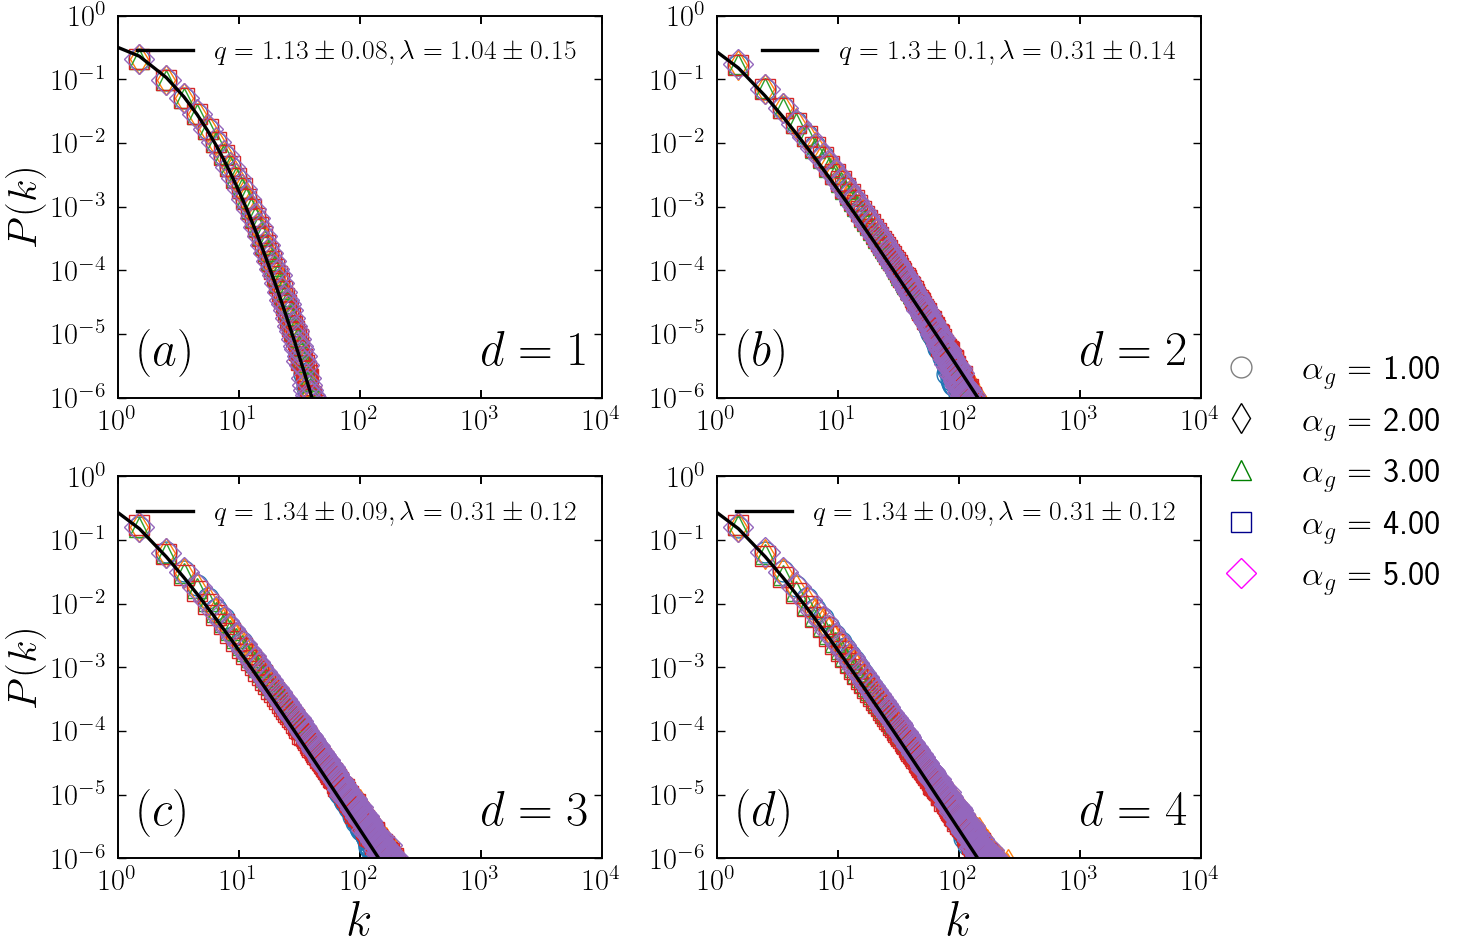

In [278]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

color = ["#808080", "black", '#008000', "#00008B", "magenta", "darkgoldenrod"]
labels_1 = [rf"$\alpha_g$ = {i:.2f}" for i in alpha_g_v]
markers = ["o", "d", "^", "s", "D"]
dim = [1, 2, 3, 4]
titles = [f"$d = {d}$" for d in dim]
labels_global = [rf"$\alpha_g$ = {alpha_g_v[i]:.2f}" for i in range(len(alpha_g_v))]
markersize = 15

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Plotando dados empíricos
for i in range(len(alpha_g_v)):
    ax[0, 0].plot(k_1d_g[i], pk_1d_g[i], markers[i], markersize = markersize, mew=1.0)
    ax[0, 1].plot(k_2d_g[i], pk_2d_g[i], markers[i], markersize = markersize, mew=1.0)
    ax[1, 0].plot(k_3d_g[i], pk_3d_g[i], markers[i], markersize = markersize, mew=1.0)
    ax[1, 1].plot(k_4d_g[i], pk_4d_g[i], markers[i], markersize = markersize, mew=1.0)

# --- Apenas curvas teóricas ajustadas (sem banda) ---
label_1d = f'$q =  {q_1d:.2f} \\pm {err_1d_q:.2f}, \\lambda = {b_1d:.2f} \\pm {err_1d_b:.2f}$'
label_2d = f'$q = {q_2d:.1f} \\pm {err_2d_q:.1f}, \\lambda = {b_2d:.2f} \\pm {err_2d_b:.2f}$'
label_3d = f'$q = {q_3d:.2f} \\pm {err_3d_q:.2f}, \\lambda = {b_3d:.2f} \\pm {err_3d_b:.2f}$'
label_4d = f'$q = {q_4d:.2f} \\pm {err_4d_q:.2f}, \\lambda = {b_4d:.2f} \\pm {err_4d_b:.2f}$'


ax[0, 0].plot(k_1d_g[1], q_exp(k_1d_g[1], q_1d, b_1d), label=label_1d, color="k", linewidth=2.4)
ax[0, 1].plot(k_2d_g[1], q_exp(k_2d_g[1], q_2d, b_2d), label=label_2d, color="k", linewidth=2.4)
ax[1, 0].plot(k_3d_g[1], q_exp(k_3d_g[1], q_3d, b_3d), label=label_3d, color="k", linewidth=2.4)
ax[1, 1].plot(k_4d_g[1], q_exp(k_4d_g[1], q_4d, b_4d), label=label_4d, color="k", linewidth=2.4)

# Subfigure labels
ax[0, 0].text(1.5, 10**(-5.5), "$(a)$", style="normal", fontsize=35)
ax[0, 1].text(1.5, 10**(-5.5), "$(b)$", style="normal", fontsize=35)
ax[1, 0].text(1.5, 10**(-5.5), "$(c)$", style="normal", fontsize=35)
ax[1, 1].text(1.5, 10**(-5.5), "$(d)$", style="normal", fontsize=35)

ax[0, 0].text(10**(3.0), 10**(-5.5), "$d = 1$", style="normal", fontsize=35)
ax[0, 1].text(10**(3.0), 10**(-5.5), "$d = 2$", style="normal", fontsize=35)
ax[1, 0].text(10**(3.0), 10**(-5.5), "$d = 3$", style="normal", fontsize=35)
ax[1, 1].text(10**(3.0), 10**(-5.5), "$d = 4$", style="normal", fontsize=35)

# Legenda global
proxy_handles = [plt.Line2D([], [], color=color[i], marker=markers[i], linestyle='None',
                            markersize=markersize, markerfacecolor='none', mew=1.0) for i in range(len(alpha_g_v))]
fig.legend(proxy_handles, labels_global, loc="center left", bbox_to_anchor=(0.80, 0.5),
           fontsize=25, frameon=False)

# Ajustes de escala e estilo
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlim([1, 10**4])
        ax[i, j].set_ylim([10**(-6), 1])
        #ax[i, j].set_title(titles[i*2+j], fontsize=20)
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        ax[i, j].legend(prop={"size":20}, fancybox=True, framealpha=0.0)
        ax[i, 0].set_ylabel(r"$P(k)$", size=30)
        ax[1, j].set_xlabel(r"$k$", size=35)
        ax[i, j].tick_params('both', labelsize=22)
        ax[i, j].xaxis.set_minor_locator(plt.NullLocator())
        ax[i, j].yaxis.set_minor_locator(plt.NullLocator())

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("../../results/distributions/degree_alpha_g.png", dpi=300)
plt.show()

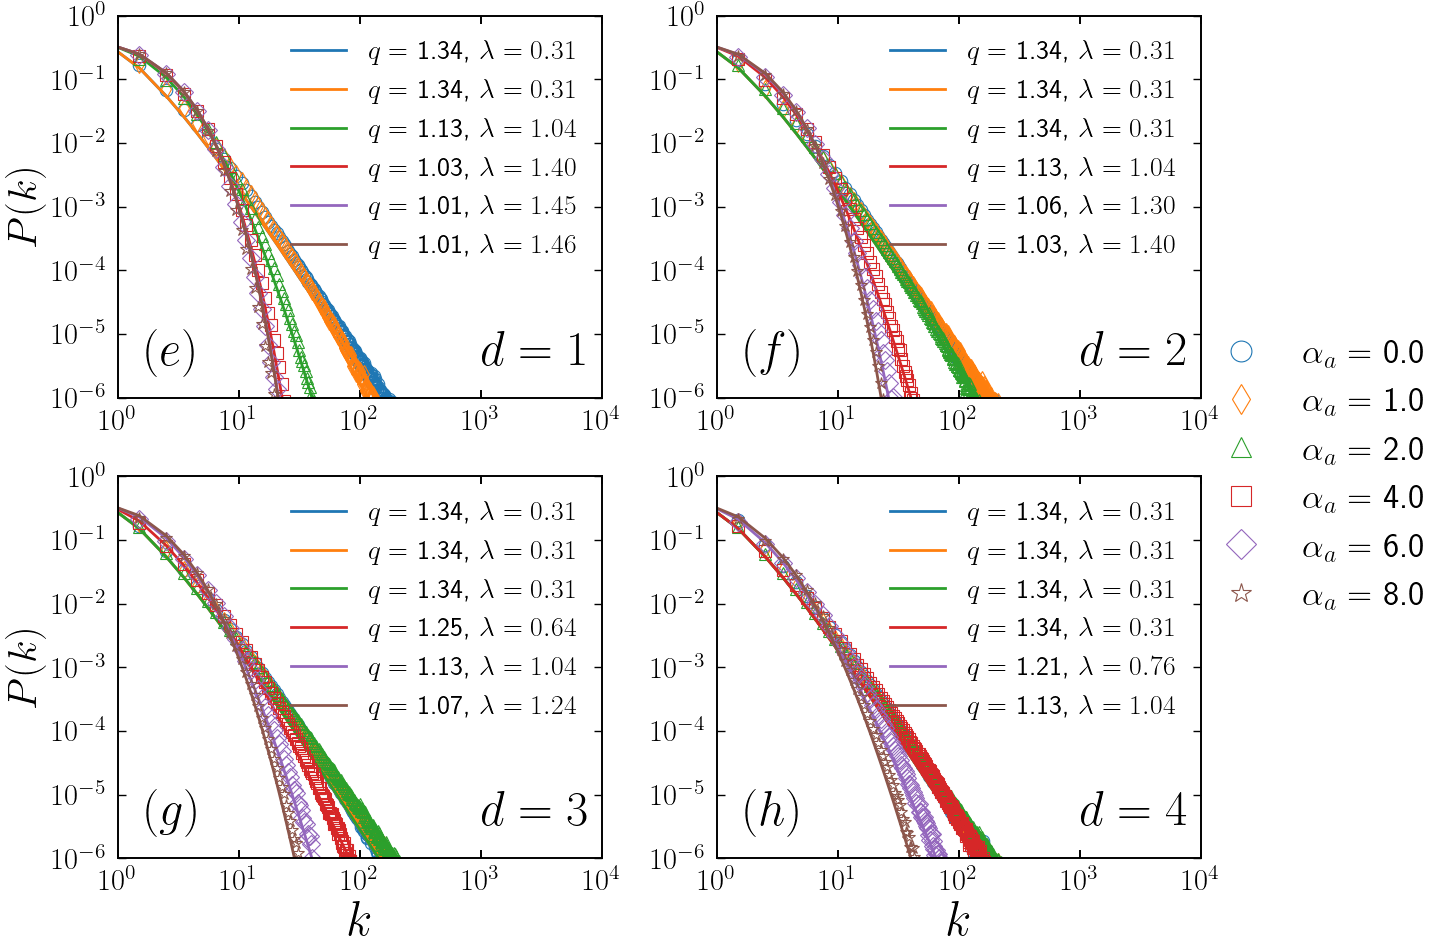

In [277]:
Q_1d, B_1d,Q_1d_err, B_1d_err = [], [], [], []
Q_2d, B_2d,Q_2d_err, B_2d_err = [], [], [], []
Q_3d, B_3d,Q_3d_err, B_3d_err = [], [], [], []
Q_4d, B_4d,Q_4d_err, B_4d_err = [], [], [], []

for i in range(len(alpha_a_v)):
    fitted_q_1d, fitted_b_1d, perr_q_1d, perr_b_1d = optimize_q_exp(k_1d_a_log[i], pk_1d_a_log[i], q_initial=q(alpha_a_v[i], 1), b_initial=eta(alpha_a_v[i], 1), delta_q=0.01, delta_b=0.01)
    fitted_q_2d, fitted_b_2d, perr_q_2d, perr_b_2d = optimize_q_exp(k_2d_a_log[i], pk_2d_a_log[i], q_initial=q(alpha_a_v[i], 2), b_initial=eta(alpha_a_v[i], 2), delta_q=0.01, delta_b=0.01)
    fitted_q_3d, fitted_b_3d, perr_q_3d, perr_b_3d = optimize_q_exp(k_3d_a_log[i], pk_3d_a_log[i], q_initial=q(alpha_a_v[i], 3), b_initial=eta(alpha_a_v[i], 3), delta_q=0.01, delta_b=0.01)
    fitted_q_4d, fitted_b_4d, perr_q_4d, perr_b_4d = optimize_q_exp(k_4d_a_log[i], pk_4d_a_log[i], q_initial=q(alpha_a_v[i], 4), b_initial=eta(alpha_a_v[i], 4), delta_q=0.01, delta_b=0.01)

    Q_1d.append(float(fitted_q_1d))
    Q_2d.append(float(fitted_q_2d))
    Q_3d.append(float(fitted_q_3d))
    Q_4d.append(float(fitted_q_4d))
    
    B_1d.append(float(fitted_b_1d))
    B_2d.append(float(fitted_b_2d))
    B_3d.append(float(fitted_b_3d))
    B_4d.append(float(fitted_b_4d))
    
    Q_1d_err.append(float(perr_q_1d))
    Q_2d_err.append(float(perr_q_2d))
    Q_3d_err.append(float(perr_q_3d))
    Q_4d_err.append(float(perr_q_4d))

    B_1d_err.append(float(perr_b_1d))
    B_2d_err.append(float(perr_b_2d))
    B_3d_err.append(float(perr_b_3d))
    B_4d_err.append(float(perr_b_4d))

# print("B=")
# print(Q_1d)
# print("B_err = ")
# print(Q_1d_err)
markers = ["o","d","^","s","D","*","H","p","P"]

labels_global = [rf"$\alpha_a$ = {alpha_a_v[i]:.1f}" for i in range(len(alpha_a_v))]
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
markersize = 15
fig, ax = plt.subplots(2, 2,figsize=(15,10))

#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
for i in range(len(alpha_a_v)):    
    # Plot data
    ax[0, 0].plot(k_1d_a[i], pk_1d_a[i],markers[i])
    ax[0, 1].plot(k_2d_a[i], pk_2d_a[i],markers[i])
    ax[1, 0].plot(k_3d_a[i], pk_3d_a[i],markers[i])
    ax[1, 1].plot(k_4d_a[i], pk_4d_a[i],markers[i])
    
    # ax[0, 0].plot(k_1d_a[i], pk_1d_a[i],markers[i],color=color[i],label=rf'{alpha_a_v[i]}',markersize=markersize,markerfacecolor='none')
    # ax[0, 1].plot(k_2d_a[i], pk_2d_a[i],markers[i],color=color[i],label=rf'{alpha_a_v[i]}',markersize=markersize,markerfacecolor='none')
    # ax[1, 0].plot(k_3d_a[i], pk_3d_a[i],markers[i],color=color[i],label=rf'{alpha_a_v[i]}',markersize=markersize,markerfacecolor='none')
    # ax[1, 1].plot(k_4d_a[i], pk_4d_a[i],markers[i],color=color[i],label=rf'{alpha_a_v[i]}',markersize=markersize,markerfacecolor='none')
    
    ax[0, 0].plot(k_1d_a[i], q_exp(k_1d_a[i], Q_1d[i], B_1d[i]), color=color[i],label=rf'$q =$ {Q_1d[i]:.2f}, $\lambda = {B_1d[i]:.2f}$', linewidth=2.0)
    ax[0, 1].plot(k_2d_a[i], q_exp(k_2d_a[i], Q_2d[i], B_2d[i]), color=color[i],label=rf'$q =$ {Q_2d[i]:.2f}, $\lambda = {B_2d[i]:.2f}$', linewidth=2.0)
    ax[1, 0].plot(k_3d_a[i], q_exp(k_3d_a[i], Q_3d[i], B_3d[i]), color=color[i],label=rf'$q =$ {Q_3d[i]:.2f}, $\lambda = {B_3d[i]:.2f}$', linewidth=2.0)
    ax[1, 1].plot(k_4d_a[i], q_exp(k_4d_a[i], Q_4d[i], B_4d[i]), color=color[i],label=rf'$q =$ {Q_4d[i]:.2f}, $\lambda = {B_4d[i]:.2f}$', linewidth=2.0)

        
# ax[0, 0].plot(k_1d_a[0],q_exp(k_1d_a[0], Q_1d[i], B_1d[i]), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)
# ax[0, 1].plot(k_2d_a[0],q_exp(k_2d_a[0], Q_2d[i], B_2d[i]), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)
# ax[1, 0].plot(k_3d_a[0],q_exp(k_3d_a[0], Q_3d[i], B_3d[i]), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)
# ax[1, 1].plot(k_4d_a[0],q_exp(k_4d_a[0], Q_4d[i], B_4d[i]), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)

# Dimension Values
ax[0, 0].text(10**3.0, 10**(-5.5), f'$d = 1$', style="normal" ,fontsize=35)
ax[0, 1].text(10**3.0, 10**(-5.5), f'$d = 2$', style="normal" ,fontsize=35)
ax[1, 0].text(10**3.0, 10**(-5.5), f'$d = 3$', style="normal" ,fontsize=35)
ax[1, 1].text(10**3.0, 10**(-5.5), f'$d = 4$', style="normal" ,fontsize=35)

ax[0, 0].text(1.7, 10**(-5.5), "$(e)$", style="normal" ,fontsize=35)
ax[0, 1].text(1.7, 10**(-5.5), "$(f)$", style="normal" ,fontsize=35)
ax[1, 0].text(1.7, 10**(-5.5), "$(g)$", style="normal" ,fontsize=35)
ax[1, 1].text(1.7, 10**(-5.5), "$(h)$", style="normal" ,fontsize=35)
# Criando proxies para a legenda global (α_a)
proxy_handles = [plt.Line2D([], [], color=color[i], marker=markers[i], linestyle='None', markersize=markersize, markerfacecolor='none') for i in range(len(alpha_a_v))]

# Adicionando legenda compartilhada global na lateral direita
fig.legend(proxy_handles, labels_global, loc="center left", bbox_to_anchor=(0.80, 0.5), fontsize=25, frameon=False)
titles = [f"$d = {d}$" for d in [1,2,3,4]]
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlim([1,10**4])
        ax[i, j].set_ylim([10**(-6),1])
        
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        #ax[i, j].set_title(titles[i*2+j], fontsize=20)
        ax[i, j].legend(prop={"size":20})
        ax[i, 0].set_ylabel(r"$P(k)$",size=30)
        ax[1, j].set_xlabel(r"$k$",size=35)
        ax[i, j].tick_params('both', labelsize=22)
        ax[i, j].xaxis.set_minor_locator(plt.NullLocator())
        ax[i, j].yaxis.set_minor_locator(plt.NullLocator())

#fig.suptitle(r'Distribuição de graus para múltiplos $\alpha_a$', fontsize=30)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("../../results/distributions/degree_alpha_a.png",dpi=300)
plt.show()

In [279]:
import math

def round_measurement(value, error):
    """
    Arredonda o erro para a primeira casa decimal não nula
    e ajusta o valor da medida para ter o mesmo número de casas decimais.
    """
    if error == 0:
        return f"{value:.1f} ± 0.0"

    # Encontra a ordem de grandeza do erro
    order = -int(math.floor(math.log10(abs(error))))
    rounded_error = round(error, order)
    
    # Caso o erro arredondado tenha ficado 0, aumentar precisão
    while rounded_error == 0.0:
        order += 1
        rounded_error = round(error, order)

    # Arredondar a medida para o mesmo número de casas decimais do erro
    rounded_value = round(value, order)
    
    # Formatar com o mesmo número de casas decimais
    fmt = f"{{:.{order}f}}"
    return f"${fmt.format(rounded_value)} \\pm {fmt.format(rounded_error)}$"


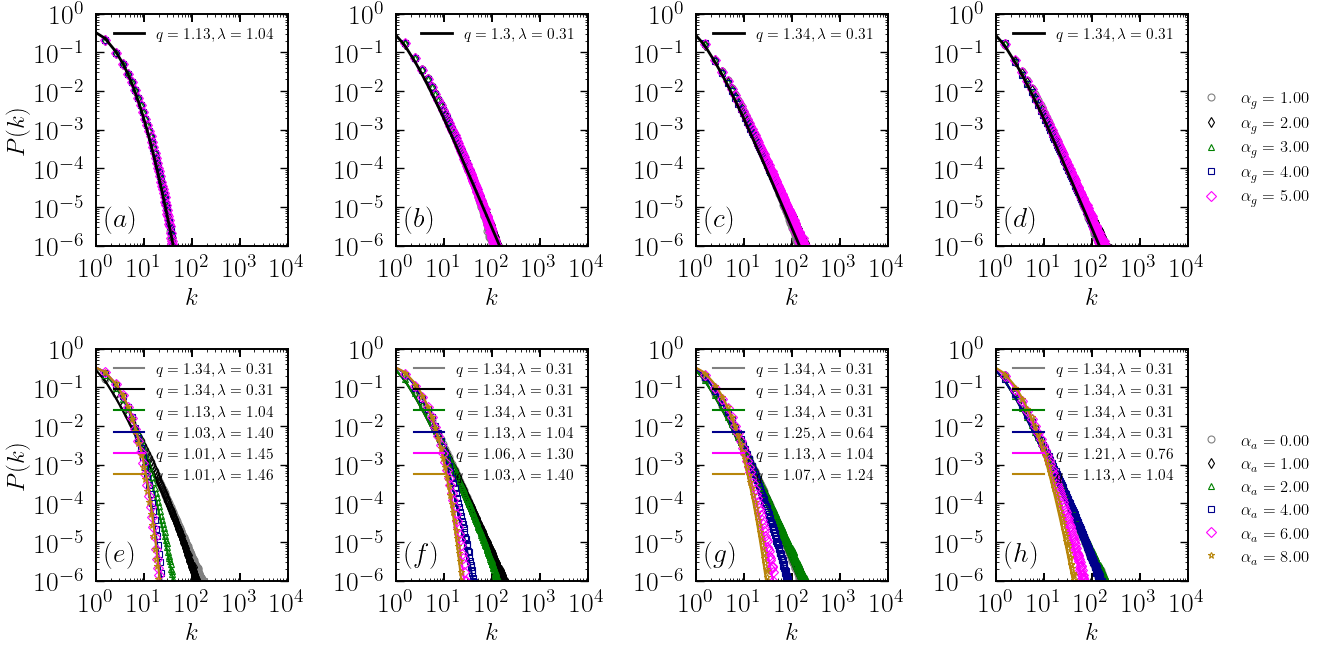

In [191]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Tamanhos quadrados para cada plot (4 quadrados por linha)
fig, ax = plt.subplots(2, 4, figsize=(14, 7), sharex=False, sharey=False)

# Estilo
markers = ["o", "d", "^", "s", "D", "*", "H", "p", "P"]
markersize = 5
colors = ['#808080', 'black', '#008000', '#00008B', 'magenta', 'darkgoldenrod']

# --- Labels ---
label_1d = f'$q =  {q_1d:.2f}, \\lambda = {b_1d:.2f} $'
label_2d = f'$q = {q_2d:.1f}, \\lambda = {b_2d:.2f} $'
label_3d = f'$q = {q_3d:.2f}, \\lambda = {b_3d:.2f} $'
label_4d = f'$q = {q_4d:.2f}, \\lambda = {b_4d:.2f} $'
labels_theory = [label_1d, label_2d, label_3d, label_4d]

labels_alpha_g = [f'$\\alpha_g = {ag:.2f}$' for ag in alpha_g_v]
labels_alpha_a = [f'$\\alpha_a = {aa:.2f}$' for aa in alpha_a_v]

label_1d_alpha_a = []
label_2d_alpha_a = []
label_3d_alpha_a = []
label_4d_alpha_a = []

q_1d_alpha_a, b_1d_alpha_a = [], []
q_2d_alpha_a, b_2d_alpha_a = [], []
q_3d_alpha_a, b_3d_alpha_a = [], []
q_4d_alpha_a, b_4d_alpha_a = [], []

for i in range(len(alpha_a_v)):
    fitted_q_1d, fitted_b_1d, perr_q_1d, perr_b_1d = optimize_q_exp(k_1d_a_log[i], pk_1d_a_log[i], q_initial=q(alpha_a_v[i], 1), b_initial=eta(alpha_a_v[i], 1), delta_q=0.01, delta_b=0.01)
    fitted_q_2d, fitted_b_2d, perr_q_2d, perr_b_2d = optimize_q_exp(k_2d_a_log[i], pk_2d_a_log[i], q_initial=q(alpha_a_v[i], 2), b_initial=eta(alpha_a_v[i], 2), delta_q=0.01, delta_b=0.01)
    fitted_q_3d, fitted_b_3d, perr_q_3d, perr_b_3d = optimize_q_exp(k_3d_a_log[i], pk_3d_a_log[i], q_initial=q(alpha_a_v[i], 3), b_initial=eta(alpha_a_v[i], 3), delta_q=0.01, delta_b=0.01)
    fitted_q_4d, fitted_b_4d, perr_q_4d, perr_b_4d = optimize_q_exp(k_4d_a_log[i], pk_4d_a_log[i], q_initial=q(alpha_a_v[i], 4), b_initial=eta(alpha_a_v[i], 4), delta_q=0.01, delta_b=0.01)
    
    label_1d_alpha_a.append(f"$q = {fitted_q_1d:.2f}, \\lambda = {fitted_b_1d:.2f}$")    
    label_2d_alpha_a.append(f"$q = {fitted_q_2d:.2f}, \\lambda = {fitted_b_2d:.2f}$")    
    label_3d_alpha_a.append(f"$q = {fitted_q_3d:.2f}, \\lambda = {fitted_b_3d:.2f}$")    
    label_4d_alpha_a.append(f"$q = {fitted_q_4d:.2f}, \\lambda = {fitted_b_4d:.2f}$")

    q_1d_alpha_a.append(fitted_q_1d)
    q_2d_alpha_a.append(fitted_q_2d)
    q_3d_alpha_a.append(fitted_q_3d)
    q_4d_alpha_a.append(fitted_q_4d)

    b_1d_alpha_a.append(fitted_b_1d)
    b_2d_alpha_a.append(fitted_b_2d)
    b_3d_alpha_a.append(fitted_b_3d)
    b_4d_alpha_a.append(fitted_b_4d)

# Painel de cima (linha 0)
for i in range(len(alpha_g_v)):    
    ax[0, 0].plot(k_1d_g[i], pk_1d_g[i], marker=markers[i], markersize=markersize,
                 linestyle='None', markerfacecolor='none', markeredgecolor=colors[i])
    ax[0, 1].plot(k_2d_g[i], pk_2d_g[i], marker=markers[i], markersize=markersize,
                 linestyle='None', markerfacecolor='none', markeredgecolor=colors[i])
    ax[0, 2].plot(k_3d_g[i], pk_3d_g[i], marker=markers[i], markersize=markersize,
                 linestyle='None', markerfacecolor='none', markeredgecolor=colors[i])
    ax[0, 3].plot(k_4d_g[i], pk_4d_g[i], marker=markers[i], markersize=markersize,
                 linestyle='None', markerfacecolor='none', markeredgecolor=colors[i])

# Curvas teóricas com label individual e legenda interna
line_teorica_ax0, = ax[0, 0].plot(k_1d_g[1], q_exp(k_1d_g[1], q_1d, b_1d), label=label_1d, color="k", linewidth=2.0)
line_teorica_ax1, = ax[0, 1].plot(k_2d_g[1], q_exp(k_2d_g[1], q_2d, b_2d), label=label_2d, color="k", linewidth=2.0)
line_teorica_ax2, = ax[0, 2].plot(k_3d_g[1], q_exp(k_3d_g[1], q_3d, b_3d), label=label_3d, color="k", linewidth=2.0)
line_teorica_ax3, = ax[0, 3].plot(k_4d_g[1], q_exp(k_4d_g[1], q_4d, b_4d), label=label_4d, color="k", linewidth=2.0)

for j in range(4):
    ax[0, j].legend(loc="upper right", fontsize=11, frameon=False)

# Criar proxies para a legenda alpha_g
handles_alpha_g = [
    mlines.Line2D([], [], marker=markers[i], color='k', linestyle='None',
                  markerfacecolor='none', markeredgecolor=colors[i], markersize=markersize,
                  label=labels_alpha_g[i])
    for i in range(len(labels_alpha_g))
]

# Legenda compartilhada alpha_g fora dos subplots
fig.legend(handles_alpha_g, labels_alpha_g, loc="center left", bbox_to_anchor=(0.86, 0.75), fontsize=12, frameon=False)

# Painel de baixo (linha 1)
for i in range(len(alpha_a_v)):
    ax[1, 0].plot(k_1d_a[i], pk_1d_a[i], marker=markers[i], markersize=markersize,
                 linestyle='None', markerfacecolor='none', markeredgecolor=colors[i])
    ax[1, 1].plot(k_2d_a[i], pk_2d_a[i], marker=markers[i], markersize=markersize,
                 linestyle='None', markerfacecolor='none', markeredgecolor=colors[i])
    ax[1, 2].plot(k_3d_a[i], pk_3d_a[i], marker=markers[i], markersize=markersize,
                 linestyle='None', markerfacecolor='none', markeredgecolor=colors[i])
    ax[1, 3].plot(k_4d_a[i], pk_4d_a[i], marker=markers[i], markersize=markersize,
                 linestyle='None', markerfacecolor='none', markeredgecolor=colors[i])
    
    ax[1, 0].plot(k_1d_a[i], q_exp(k_1d_a[i],q_1d_alpha_a[i], b_1d_alpha_a[i]),color=colors[i], label = label_1d_alpha_a[i])
    ax[1, 1].plot(k_2d_a[i], q_exp(k_2d_a[i],q_2d_alpha_a[i], b_2d_alpha_a[i]),color=colors[i], label = label_2d_alpha_a[i])
    ax[1, 2].plot(k_3d_a[i], q_exp(k_3d_a[i],q_3d_alpha_a[i], b_3d_alpha_a[i]),color=colors[i], label = label_3d_alpha_a[i])
    ax[1, 3].plot(k_4d_a[i], q_exp(k_4d_a[i],q_4d_alpha_a[i], b_4d_alpha_a[i]),color=colors[i], label = label_4d_alpha_a[i])

for j in range(4):
    ax[1, j].legend(loc="upper right", fontsize=11, frameon=False)

handles_alpha_a = [
    mlines.Line2D([], [], marker=markers[i], color='k', linestyle='None',
                  markerfacecolor='none', markeredgecolor=colors[i], markersize=markersize,
                  label=labels_alpha_a[i])
    for i in range(len(labels_alpha_a))
]

fig.legend(handles_alpha_a, labels_alpha_a, loc="center left", bbox_to_anchor=(0.86, 0.25), fontsize=12, frameon=False)

# Etiquetas de eixos
from matplotlib.ticker import LogLocator, LogFormatterMathtext

for i in range(4):
    for j in range(2):
        ax[j, i].set_xlabel(r"$k$", fontsize=18)
        ax[j, i].set_xscale('log')
        ax[j, i].set_yscale('log')
        ax[j, i].set_xlim([1, 1e4])
        ax[j, i].set_ylim([1e-6, 1])

        ax[j, i].xaxis.set_major_locator(LogLocator(base=10.0, numticks=5))
        ax[j, i].yaxis.set_major_locator(LogLocator(base=10.0, numticks=7))
        ax[j, i].xaxis.set_major_formatter(LogFormatterMathtext())
        ax[j, i].yaxis.set_major_formatter(LogFormatterMathtext())
        ax[j, i].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
        ax[j, i].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))

# y-labels
ax[0, 0].set_ylabel(r"$P(k)$", fontsize=18)
ax[1, 0].set_ylabel(r"$P(k)$", fontsize=18)

# Rótulos
ax[0, 0].text(1.5, 10**(-5.5), "$(a)$", fontsize=20)
ax[0, 1].text(1.5, 10**(-5.5), "$(b)$", fontsize=20)
ax[0, 2].text(1.5, 10**(-5.5), "$(c)$", fontsize=20)
ax[0, 3].text(1.5, 10**(-5.5), "$(d)$", fontsize=20)
ax[1, 0].text(1.5, 10**(-5.5), "$(e)$", fontsize=20)
ax[1, 1].text(1.5, 10**(-5.5), "$(f)$", fontsize=20)
ax[1, 2].text(1.5, 10**(-5.5), "$(g)$", fontsize=20)
ax[1, 3].text(1.5, 10**(-5.5), "$(h)$", fontsize=20)

plt.tight_layout(rect=[0, 0, 0.9, 1])
# plt.savefig("Fig02_painel.pdf", dpi=300)
plt.show()

In [79]:
for i in range(len(alpha_a_v)):
    fitted_q_1d, fitted_b_1d, perr_q_1d, perr_b_1d = optimize_q_exp(k_1d_a_log[i], pk_1d_a_log[i], q_initial=q(alpha_a_v[i], 1), b_initial=eta(alpha_a_v[i], 1), delta_q=0.005, delta_b=0.01)
    fitted_q_2d, fitted_b_2d, perr_q_2d, perr_b_2d = optimize_q_exp(k_2d_a_log[i], pk_2d_a_log[i], q_initial=q(alpha_a_v[i], 2), b_initial=eta(alpha_a_v[i], 2), delta_q=0.005, delta_b=0.01)
    fitted_q_3d, fitted_b_3d, perr_q_3d, perr_b_3d = optimize_q_exp(k_3d_a_log[i], pk_3d_a_log[i], q_initial=q(alpha_a_v[i], 3), b_initial=eta(alpha_a_v[i], 3), delta_q=0.005, delta_b=0.01)
    fitted_q_4d, fitted_b_4d, perr_q_4d, perr_b_4d = optimize_q_exp(k_4d_a_log[i], pk_4d_a_log[i], q_initial=q(alpha_a_v[i], 4), b_initial=eta(alpha_a_v[i], 4), delta_q=0.005, delta_b=0.01)
    print(round_measurement(fitted_b_1d, perr_b_1d))

$0.3 \pm 0.3$
$0.3 \pm 0.4$
$1.0 \pm 0.4$
$1.4 \pm 0.5$
$1.5 \pm 0.4$
$1.5 \pm 0.4$


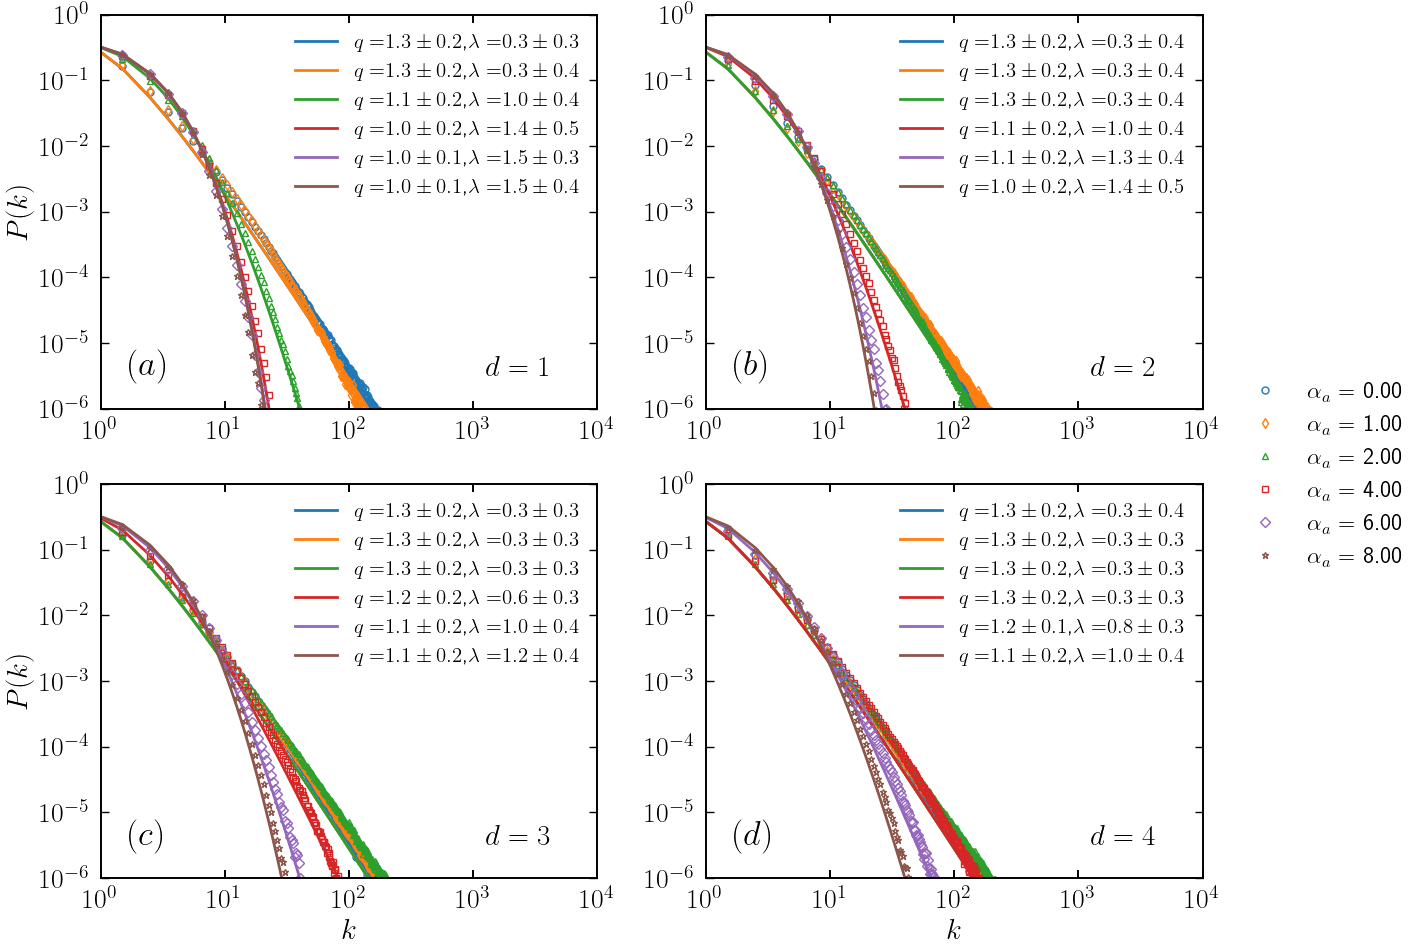

In [206]:
Q_1d, B_1d,Q_1d_err, B_1d_err = [], [], [], []
Q_2d, B_2d,Q_2d_err, B_2d_err = [], [], [], []
Q_3d, B_3d,Q_3d_err, B_3d_err = [], [], [], []
Q_4d, B_4d,Q_4d_err, B_4d_err = [], [], [], []

for i in range(len(alpha_a_v)):
    fitted_q_1d, fitted_b_1d, perr_q_1d, perr_b_1d = optimize_q_exp(k_1d_a_log[i], pk_1d_a_log[i], q_initial=q(alpha_a_v[i], 1), b_initial=eta(alpha_a_v[i], 1), delta_q=0.01, delta_b=0.01)
    fitted_q_2d, fitted_b_2d, perr_q_2d, perr_b_2d = optimize_q_exp(k_2d_a_log[i], pk_2d_a_log[i], q_initial=q(alpha_a_v[i], 2), b_initial=eta(alpha_a_v[i], 2), delta_q=0.01, delta_b=0.01)
    fitted_q_3d, fitted_b_3d, perr_q_3d, perr_b_3d = optimize_q_exp(k_3d_a_log[i], pk_3d_a_log[i], q_initial=q(alpha_a_v[i], 3), b_initial=eta(alpha_a_v[i], 3), delta_q=0.01, delta_b=0.01)
    fitted_q_4d, fitted_b_4d, perr_q_4d, perr_b_4d = optimize_q_exp(k_4d_a_log[i], pk_4d_a_log[i], q_initial=q(alpha_a_v[i], 4), b_initial=eta(alpha_a_v[i], 4), delta_q=0.01, delta_b=0.01)

    Q_1d.append(float(fitted_q_1d))
    Q_2d.append(float(fitted_q_2d))
    Q_3d.append(float(fitted_q_3d))
    Q_4d.append(float(fitted_q_4d))
    
    B_1d.append(float(fitted_b_1d))
    B_2d.append(float(fitted_b_2d))
    B_3d.append(float(fitted_b_3d))
    B_4d.append(float(fitted_b_4d))
    
    Q_1d_err.append(float(perr_q_1d))
    Q_2d_err.append(float(perr_q_2d))
    Q_3d_err.append(float(perr_q_3d))
    Q_4d_err.append(float(perr_q_4d))

    B_1d_err.append(float(perr_b_1d))
    B_2d_err.append(float(perr_b_2d))
    B_3d_err.append(float(perr_b_3d))
    B_4d_err.append(float(perr_b_4d))

# print("B=")
# print(Q_1d)
# print("B_err = ")
# print(Q_1d_err)
markers = ["o","d","^","s","D","*","H","p","P"]

labels_global = [rf"$\alpha_a$ = {alpha_a_v[i]:.2f}" for i in range(len(alpha_a_v))]
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
markersize = 5
fig, ax = plt.subplots(2, 2,figsize=(15,10))

#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
for i in range(len(alpha_a_v)):    
    # Plot data
    ax[0, 0].plot(k_1d_a[i], pk_1d_a[i],markers[i], markersize = markersize, mew=1.0)
    ax[0, 1].plot(k_2d_a[i], pk_2d_a[i],markers[i], markersize = markersize, mew=1.0)
    ax[1, 0].plot(k_3d_a[i], pk_3d_a[i],markers[i], markersize = markersize, mew=1.0)
    ax[1, 1].plot(k_4d_a[i], pk_4d_a[i],markers[i], markersize = markersize, mew=1.0)
    
    # ax[0, 0].plot(k_1d_a[i], pk_1d_a[i],markers[i],color=color[i],label=rf'{alpha_a_v[i]}',markersize=markersize,markerfacecolor='none')
    # ax[0, 1].plot(k_2d_a[i], pk_2d_a[i],markers[i],color=color[i],label=rf'{alpha_a_v[i]}',markersize=markersize,markerfacecolor='none')
    # ax[1, 0].plot(k_3d_a[i], pk_3d_a[i],markers[i],color=color[i],label=rf'{alpha_a_v[i]}',markersize=markersize,markerfacecolor='none')
    # ax[1, 1].plot(k_4d_a[i], pk_4d_a[i],markers[i],color=color[i],label=rf'{alpha_a_v[i]}',markersize=markersize,markerfacecolor='none')
    
    ax[0, 0].plot(k_1d_a[i], q_exp(k_1d_a[i], Q_1d[i], B_1d[i]), color=color[i],label='$q =$' + round_measurement(Q_1d[i], Q_1d_err[i]) + ',$\\lambda = $' + round_measurement(B_1d[i], B_1d_err[i]), linewidth=2.0)
    ax[0, 1].plot(k_2d_a[i], q_exp(k_2d_a[i], Q_2d[i], B_2d[i]), color=color[i],label='$q =$' + round_measurement(Q_2d[i], Q_2d_err[i]) + ',$\\lambda = $' + round_measurement(B_2d[i], B_2d_err[i]), linewidth=2.0)
    ax[1, 0].plot(k_3d_a[i], q_exp(k_3d_a[i], Q_3d[i], B_3d[i]), color=color[i],label='$q =$' + round_measurement(Q_3d[i], Q_3d_err[i]) + ',$\\lambda = $' + round_measurement(B_3d[i], B_3d_err[i]), linewidth=2.0)
    ax[1, 1].plot(k_4d_a[i], q_exp(k_4d_a[i], Q_4d[i], B_4d[i]), color=color[i],label='$q =$' + round_measurement(Q_4d[i], Q_4d_err[i]) + ',$\\lambda = $' + round_measurement(B_4d[i], B_4d_err[i]), linewidth=2.0)

        
# ax[0, 0].plot(k_1d_a[0],q_exp(k_1d_a[0], Q_1d[i], B_1d[i]), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)
# ax[0, 1].plot(k_2d_a[0],q_exp(k_2d_a[0], Q_2d[i], B_2d[i]), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)
# ax[1, 0].plot(k_3d_a[0],q_exp(k_3d_a[0], Q_3d[i], B_3d[i]), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)
# ax[1, 1].plot(k_4d_a[0],q_exp(k_4d_a[0], Q_4d[i], B_4d[i]), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)

# Dimension Values
# ax[0, 0].text(1.7, 10**(-5.5), f'$d = 1$', style="normal" ,fontsize=17, bbox={'facecolor': color[0], 'alpha': 0.2, 'pad': 11})
# ax[0, 1].text(1.7, 10**(-5.5), f'$d = 2$', style="normal" ,fontsize=17, bbox={'facecolor': color[1], 'alpha': 0.2, 'pad': 11})
# ax[1, 0].text(1.7, 10**(-5.5), f'$d = 3$', style="normal" ,fontsize=17, bbox={'facecolor': color[2], 'alpha': 0.2, 'pad': 11})
# ax[1, 1].text(1.7, 10**(-5.5), f'$d = 4$', style="normal" ,fontsize=17, bbox={'facecolor': color[3], 'alpha': 0.2, 'pad': 11})

ax[0, 0].text(1.7, 10**(-5.5), "$(a)$", style="normal" ,fontsize=25)
ax[0, 1].text(1.7, 10**(-5.5), "$(b)$", style="normal" ,fontsize=25)
ax[1, 0].text(1.7, 10**(-5.5), "$(c)$", style="normal" ,fontsize=25)
ax[1, 1].text(1.7, 10**(-5.5), "$(d)$", style="normal" ,fontsize=25)

ax[0, 0].text(10**(3.1), 10**(-5.5), "$d = 1$", style="normal" ,fontsize=21)
ax[0, 1].text(10**(3.1), 10**(-5.5), "$d = 2$", style="normal" ,fontsize=21)
ax[1, 0].text(10**(3.1), 10**(-5.5), "$d = 3$", style="normal" ,fontsize=21)
ax[1, 1].text(10**(3.1), 10**(-5.5), "$d = 4$", style="normal" ,fontsize=21)
# Criando proxies para a legenda global (α_a)
proxy_handles = [plt.Line2D([], [], color=color[i], marker=markers[i], linestyle='None', markersize=markersize, markerfacecolor='none', mew=1.0) for i in range(len(alpha_a_v))]

# Adicionando legenda compartilhada global na lateral direita
fig.legend(proxy_handles, labels_global, loc="center left", bbox_to_anchor=(0.83, 0.5), fontsize=17, frameon=False)
titles = [f"$d = {d}$" for d in [1,2,3,4]]
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlim([1,10**4])
        ax[i, j].set_ylim([10**(-6),1])
        
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        #ax[i, j].set_title(titles[i*2+j], fontsize=20)
        ax[i, j].legend(prop={"size":15})
        ax[i, 0].set_ylabel(r"$P(k)$",size=21)
        ax[1, j].set_xlabel(r"$k$",size=21)
        #ax[i, j].tick_params('both', labelsize=21)
        ax[i, j].xaxis.set_minor_locator(plt.NullLocator())
        ax[i, j].yaxis.set_minor_locator(plt.NullLocator())

#fig.suptitle(r'Distribuição de graus para múltiplos $\alpha_a$', fontsize=30)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("../../results/distributions/degree_alpha_a.png",dpi=300)
plt.show()

In [280]:
alpha_a_v = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
k_1d_g, pk_1d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_2d_g, pk_2d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_3d_g, pk_3d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_4d_g, pk_4d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]

k_1d_a, pk_1d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_2d_a, pk_2d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_3d_a, pk_3d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_4d_a, pk_4d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]

In [281]:
for i in range(len(alpha_g_v)):
    df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')
    df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')
    df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')
    df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')

    k_1d_g[i], pk_1d_g[i] = df_1d["ds"], df_1d["pds"]
    k_2d_g[i], pk_2d_g[i] = df_2d["ds"], df_2d["pds"]
    k_3d_g[i], pk_3d_g[i] = df_3d["ds"], df_3d["pds"]
    k_4d_g[i], pk_4d_g[i] = df_4d["ds"], df_4d["pds"]

In [282]:

for i in range(len(alpha_a_v)):
        df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/distances_distribution_log.csv", delimiter=' ')
        df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/distances_distribution_log.csv", delimiter=' ')
        df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/distances_distribution_log.csv", delimiter=' ')
        df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/distances_distribution_log.csv", delimiter=' ')

        k_1d_a[i], pk_1d_a[i] = df_1d["ds"], df_1d["pds"]
        k_2d_a[i], pk_2d_a[i] = df_2d["ds"], df_2d["pds"]
        k_3d_a[i], pk_3d_a[i] = df_3d["ds"], df_3d["pds"]
        k_4d_a[i], pk_4d_a[i] = df_4d["ds"], df_4d["pds"]

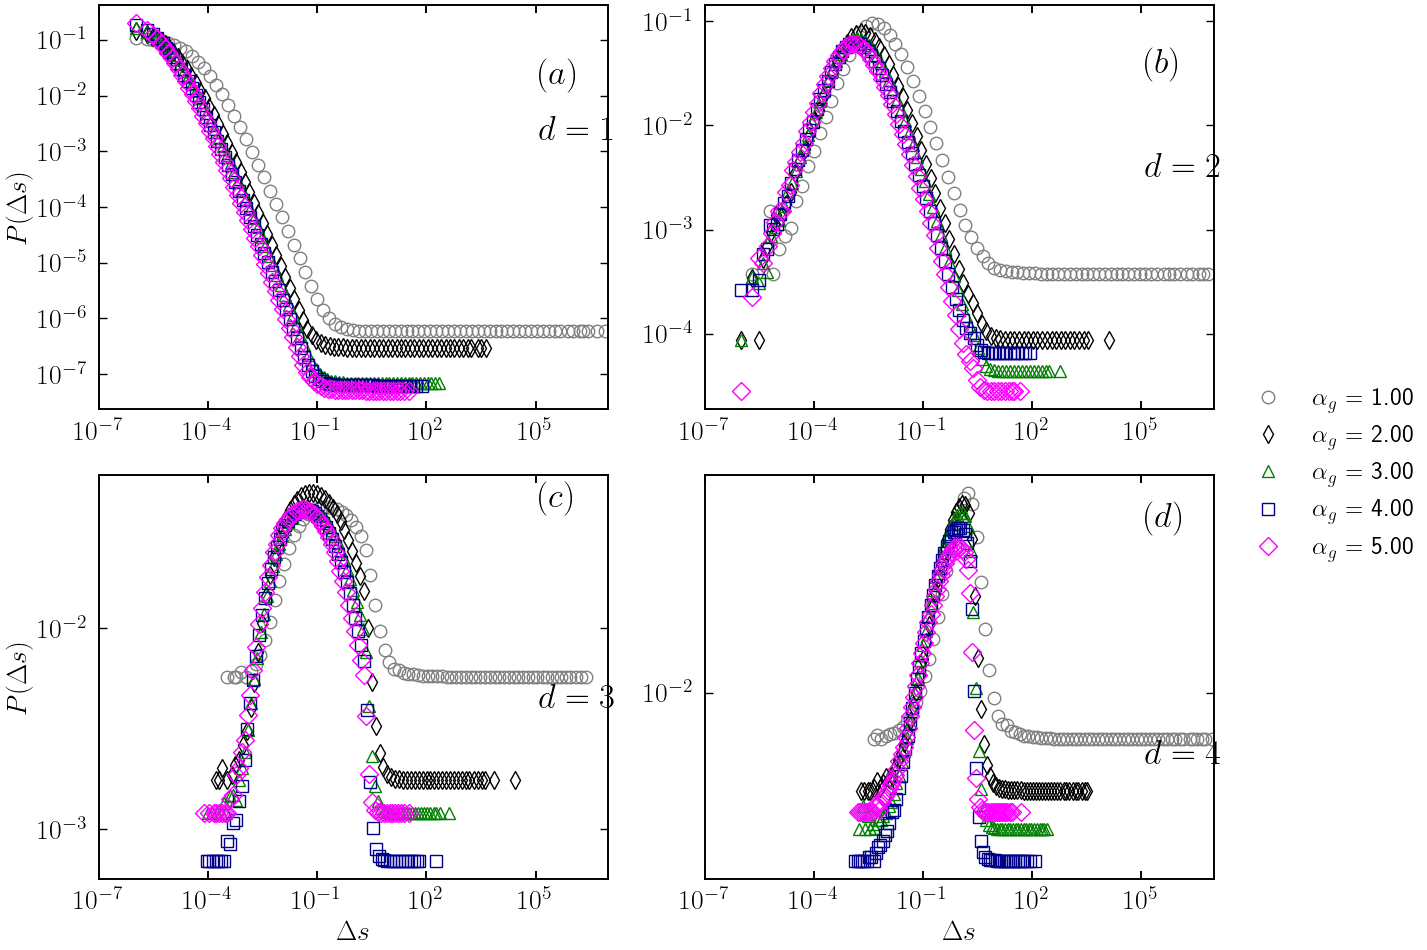

In [287]:
color = ["#808080","black",'#008000',"#00008B","magenta","darkgoldenrod"]
markers = ["o","d","^","s","D", "*"]
#markers = ["o","o","o","o","o"]
labels_global = [rf"$\alpha_g$ = {i:.2f}" for i in alpha_g_v]
markersize = 9
fig, ax = plt.subplots(2, 2,figsize=(15,10))
#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
for i in range(len(alpha_g_v)):
    kwargs = dict(
        marker=markers[i],
        markersize=markersize,
        linestyle='None',
        markerfacecolor='none',     # vazio por dentro
        markeredgecolor=color[i],   # cor do contorno
        markeredgewidth=1.0
    )
    ax[0,0].plot(k_1d_g[i], pk_1d_g[i], **kwargs)
    ax[0,1].plot(k_2d_g[i], pk_2d_g[i], **kwargs)
    ax[1,0].plot(k_3d_g[i], pk_3d_g[i], **kwargs)
    ax[1,1].plot(k_4d_g[i], pk_4d_g[i], **kwargs)
    
thickness_axes =  2.4
parts_of_graphic = ['top', 'bottom', 'left', 'right']
proxy_handles = [
    plt.Line2D(
        [], [],
        linestyle='None',
        marker=markers[i],
        markersize=markersize,
        markerfacecolor='none',
        markeredgecolor=color[i],
        markeredgewidth=1.0
    )
    for i in range(len(alpha_g_v))
]
fig.legend(proxy_handles, labels_global,
           loc="center left", bbox_to_anchor=(0.83, 0.5),
           fontsize=18, frameon=False)


# for f, d in zip(ax.flatten(), dim):
#     f.set_title(f"$d = {d}$")

ax[0, 0].text(10**5.1, 10**(-1.8), "$(a)$", style="normal" ,fontsize=25)
ax[0, 1].text(10**5.1, 10**(-1.5), "$(b)$", style="normal" ,fontsize=25)
ax[1, 0].text(10**5.1, 10**(-1.4), "$(c)$", style="normal" ,fontsize=25)
ax[1, 1].text(10**5.1, 10**(-1.3), "$(d)$", style="normal" ,fontsize=25)


ax[0, 0].text(10**(5.1), 10**(-2.8), f'$d = 1$', style="normal" ,fontsize=25)
ax[0, 1].text(10**(5.1), 10**(-2.5), f'$d = 2$', style="normal" ,fontsize=25)
ax[1, 0].text(10**(5.1), 10**(-2.4), f'$d = 3$', style="normal" ,fontsize=25)
ax[1, 1].text(10**(5.1), 10**(-2.3), f'$d = 4$', style="normal" ,fontsize=25)

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlim([10**(-7),10**7])
        #ax[i, j].set_ylim([10**(-7),1])
        
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        #ax[i, j].legend(prop={"size":16},fancybox=True,framealpha=0.0)
        ax[i, 0].set_ylabel(r"$P(\Delta s)$")
        ax[1, j].set_xlabel(r"$\Delta s$")
        ax[i, j].xaxis.set_minor_locator(plt.NullLocator())
        ax[i, j].yaxis.set_minor_locator(plt.NullLocator())
        #ax[i, j].tick_params('both', labelsize=21)
        #ax[i,j].tick_params(which='minor', width=1.4,length=4,labelsize=18)
        
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("../../results/distributions/distances_alpha_g_N100000.svg", dpi =300)
plt.show()

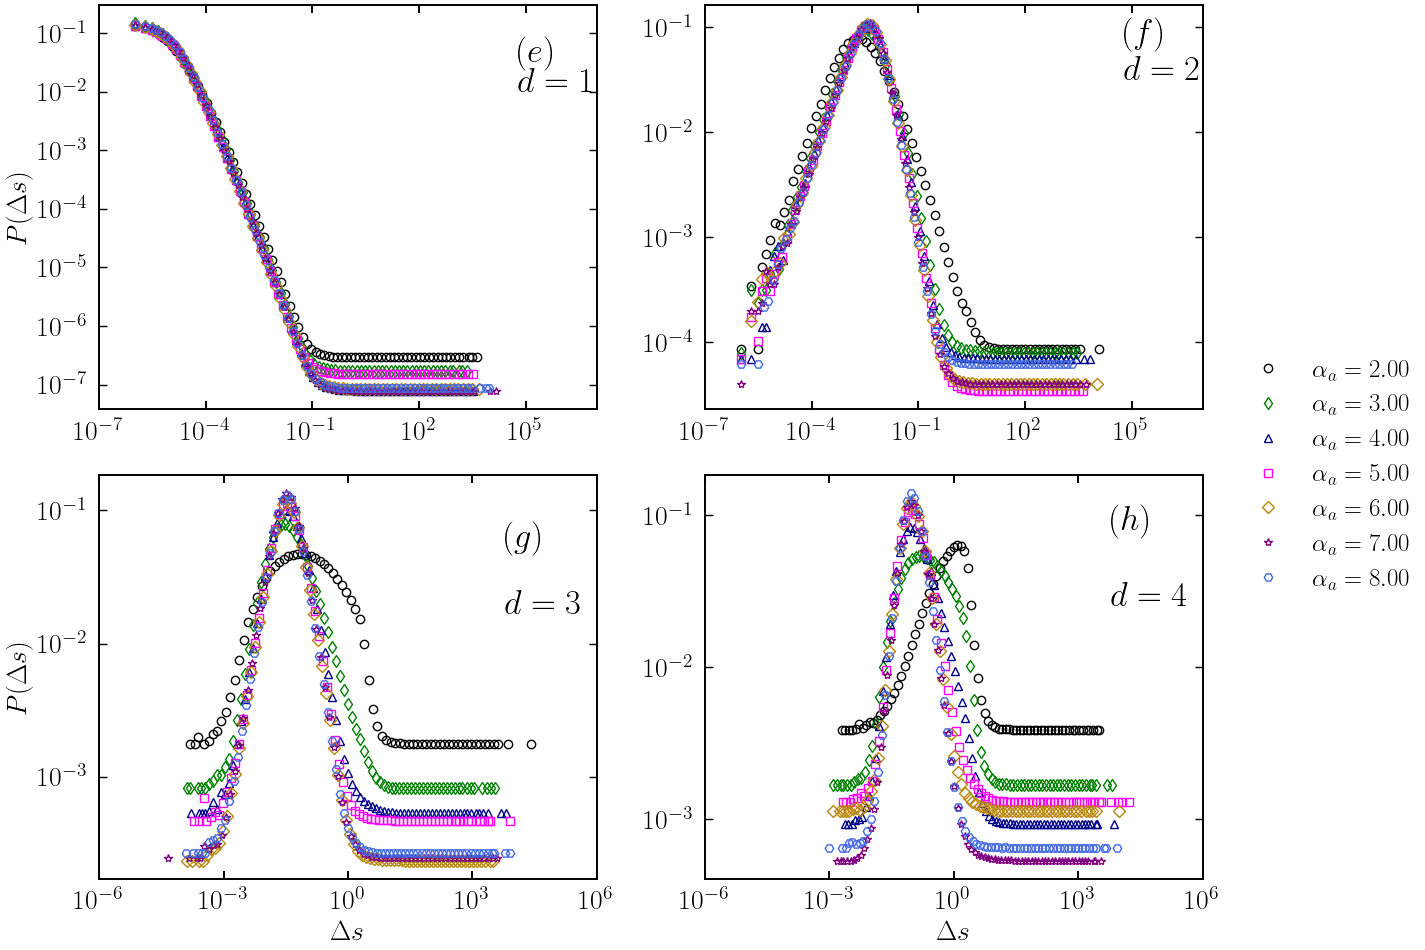

In [288]:
color = ["black",'#008000',"#00008B","magenta","darkgoldenrod","purple","royalblue", "silver"]

markers = ["o","d","^","s","D","*","H","p","P"]
labels_global = [rf"$\alpha_a = {alpha_a_v[i]:.2f}$" for i in range(len(alpha_a_v))]
#markers = ["o","o","o","o","o"]
labels_1 = [rf"$\alpha_a = {alpha_a_v[i]:.2f}$" for i in range(len(alpha_a_v))]
markersize = 6
fig, ax = plt.subplots(2, 2,figsize=(15,10))
#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
for i in range(len(alpha_a_v)):
    kwargs = dict(
        marker=markers[i],
        markersize=markersize,
        linestyle='None',
        markerfacecolor='none',     # vazio por dentro
        markeredgecolor=color[i],   # cor do contorno
        markeredgewidth=1.0
    )
    ax[0,0].plot(k_1d_a[i], pk_1d_a[i], **kwargs)
    ax[0,1].plot(k_2d_a[i], pk_2d_a[i], **kwargs)
    ax[1,0].plot(k_3d_a[i], pk_3d_a[i], **kwargs)
    ax[1,1].plot(k_4d_a[i], pk_4d_a[i], **kwargs)


thickness_axes =  2.4
# Criando proxies para a legenda global (α_a)
proxy_handles = [
    plt.Line2D(
        [], [],
        linestyle='None',
        marker=markers[i],
        markersize=markersize,
        markerfacecolor='none',
        markeredgecolor=color[i],
        markeredgewidth=1.0
    )
    for i in range(len(alpha_a_v))
]
fig.legend(proxy_handles, labels_global,
           loc="center left", bbox_to_anchor=(0.83, 0.5),
           fontsize=18, frameon=False)



ax[0, 0].text(10**(4.8), 10**(-1.5), "$(e)$", style="normal" ,fontsize=25)
ax[0, 1].text(10**(4.8), 10**(-1.15), "$(f)$", style="normal" ,fontsize=25)
ax[1, 0].text(10**3.8, 10**(-1.28), "$(g)$", style="normal" ,fontsize=25)
ax[1, 1].text(10**3.8, 10**(-1.10), "$(h)$", style="normal" ,fontsize=25)

# ax[0, 0].text(10**(4.8), 10**(-1.0), f'$d = 1$', style="normal" ,fontsize=17, bbox={'facecolor': color[0], 'alpha': 0.2, 'pad': 11})
# ax[0, 1].text(10**(4.8), 10**(-1.00), f'$d = 2$', style="normal" ,fontsize=17, bbox={'facecolor': color[1], 'alpha': 0.2, 'pad': 11})
# ax[1, 0].text(10**(3.8), 10**(-1.14), f'$d = 3$', style="normal" ,fontsize=17, bbox={'facecolor': color[2], 'alpha': 0.2, 'pad': 11})
# ax[1, 1].text(10**(3.8), 10**(-1.00), f'$d = 4$', style="normal" ,fontsize=17, bbox={'facecolor': color[3], 'alpha': 0.2, 'pad': 11})
ax[0, 0].text(10**(4.8), 10**(-2.0), f'$d = 1$', style="normal" ,fontsize=25)
ax[0, 1].text(10**(4.8), 10**(-1.50), f'$d = 2$', style="normal" ,fontsize=25)
ax[1, 0].text(10**(3.8), 10**(-1.78), f'$d = 3$', style="normal" ,fontsize=25)
ax[1, 1].text(10**(3.8), 10**(-1.60), f'$d = 4$', style="normal" ,fontsize=25)
# for f, d in zip(ax.flatten(), dim):
#     f.set_title(f"$d = {d}$", fontsize=18)

parts_of_graphic = ['top', 'bottom', 'left', 'right']
for i in range(2):
    for j in range(2):
        if(i == 0):
            ax[i, j].set_xlim([10**(-7),10**7])
#            ax[i, j].set_ylim([10**(-8),10**0])
        else:
            ax[i, j].set_xlim([10**(-6),10**6])
            #ax[i, j].set_ylim([10**(-4),10**0])
        #ax[i, j].set_ylim([10**(-6),1])
        
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        #ax[i, j].legend(prop={"size":16},fancybox=True,framealpha=0.0)
        ax[i, 0].set_ylabel(r"$P(\Delta s)$")
        ax[1, j].set_xlabel(r"$\Delta s$")
        ax[i, j].xaxis.set_minor_locator(plt.NullLocator())
        ax[i, j].yaxis.set_minor_locator(plt.NullLocator())
        #ax[i, j].tick_params('both', labelsize=21)
        #ax[i,j].tick_params(which='minor', width=1.4,length=4,labelsize=18)
        
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("../../results/distributions/distances_alpha_a_N100000.svg", dpi =300)
plt.show()

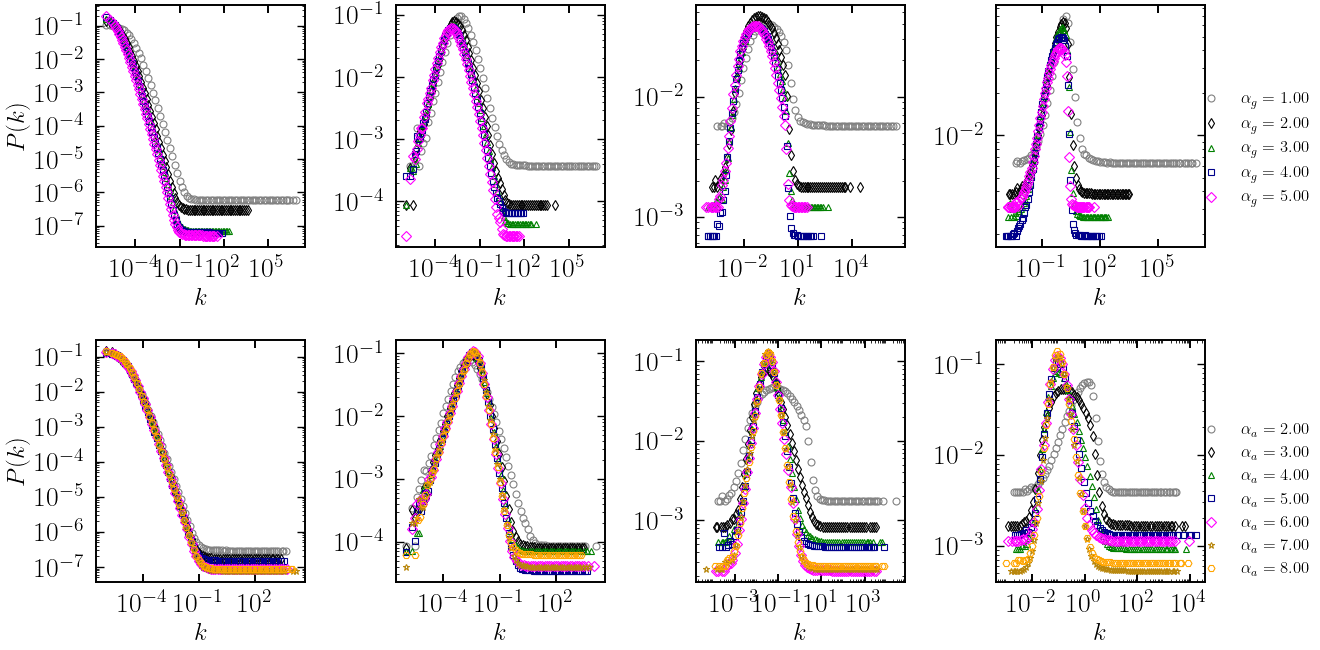

In [227]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Tamanhos quadrados para cada plot (4 quadrados por linha)
fig, ax = plt.subplots(2, 4, figsize=(14, 7), sharex=False, sharey=False)

# Estilo
markers = ["o", "d", "^", "s", "D", "*", "H", "p", "P"]
markersize = 5
colors = ['#808080', 'black', '#008000', '#00008B', 'magenta', 'darkgoldenrod', "orange"]

# --- Labels ---
label_1d = f'$q =  {q_1d:.2f}, \\lambda = {b_1d:.2f} $'
label_2d = f'$q = {q_2d:.1f}, \\lambda = {b_2d:.2f} $'
label_3d = f'$q = {q_3d:.2f}, \\lambda = {b_3d:.2f} $'
label_4d = f'$q = {q_4d:.2f}, \\lambda = {b_4d:.2f} $'
labels_theory = [label_1d, label_2d, label_3d, label_4d]

labels_alpha_g = [f'$\\alpha_g = {ag:.2f}$' for ag in alpha_g_v]
labels_alpha_a = [f'$\\alpha_a = {aa:.2f}$' for aa in alpha_a_v]

# Painel de cima (linha 0)
for i in range(len(alpha_g_v)):    
    ax[0, 0].plot(k_1d_g[i], pk_1d_g[i], marker=markers[i], markersize=markersize,
                 linestyle='None', markerfacecolor='none', markeredgecolor=colors[i])
    ax[0, 1].plot(k_2d_g[i], pk_2d_g[i], marker=markers[i], markersize=markersize,
                 linestyle='None', markerfacecolor='none', markeredgecolor=colors[i])
    ax[0, 2].plot(k_3d_g[i], pk_3d_g[i], marker=markers[i], markersize=markersize,
                 linestyle='None', markerfacecolor='none', markeredgecolor=colors[i])
    ax[0, 3].plot(k_4d_g[i], pk_4d_g[i], marker=markers[i], markersize=markersize,
                 linestyle='None', markerfacecolor='none', markeredgecolor=colors[i])


#for j in range(4):
    #ax[0, j].legend(loc="upper right", fontsize=11, frameon=False)

# Criar proxies para a legenda alpha_g
handles_alpha_g = [
    mlines.Line2D([], [], marker=markers[i], color='k', linestyle='None',
                  markerfacecolor='none', markeredgecolor=colors[i], markersize=markersize,
                  label=labels_alpha_g[i])
    for i in range(len(labels_alpha_g))
]

# Legenda compartilhada alpha_g fora dos subplots
fig.legend(handles_alpha_g, labels_alpha_g, loc="center left", bbox_to_anchor=(0.86, 0.75), fontsize=12, frameon=False)

# Painel de baixo (linha 1)
for i in range(len(alpha_a_v)):
    ax[1, 0].plot(k_1d_a[i], pk_1d_a[i], marker=markers[i], markersize=markersize,
                 linestyle='None', markerfacecolor='none', markeredgecolor=colors[i])
    ax[1, 1].plot(k_2d_a[i], pk_2d_a[i], marker=markers[i], markersize=markersize,
                 linestyle='None', markerfacecolor='none', markeredgecolor=colors[i])
    ax[1, 2].plot(k_3d_a[i], pk_3d_a[i], marker=markers[i], markersize=markersize,
                 linestyle='None', markerfacecolor='none', markeredgecolor=colors[i])
    ax[1, 3].plot(k_4d_a[i], pk_4d_a[i], marker=markers[i], markersize=markersize,
                 linestyle='None', markerfacecolor='none', markeredgecolor=colors[i])

# for j in range(4):
#     ax[1, j].legend(loc="upper right", fontsize=11, frameon=False)

handles_alpha_a = [
    mlines.Line2D([], [], marker=markers[i], color='k', linestyle='None',
                  markerfacecolor='none', markeredgecolor=colors[i], markersize=markersize,
                  label=labels_alpha_a[i])
    for i in range(len(labels_alpha_a))
]

fig.legend(handles_alpha_a, labels_alpha_a, loc="center left", bbox_to_anchor=(0.86, 0.25), fontsize=12, frameon=False)

# Etiquetas de eixos
from matplotlib.ticker import LogLocator, LogFormatterMathtext

for i in range(4):
    for j in range(2):
        ax[j, i].set_xlabel(r"$k$", fontsize=18)
        ax[j, i].set_xscale('log')
        ax[j, i].set_yscale('log')
        
        #ax[j, i].set_xlim([1, 1e4])
        #ax[j, i].set_ylim([1e-6, 1])

        ax[j, i].xaxis.set_major_locator(LogLocator(base=10.0, numticks=5))
        ax[j, i].yaxis.set_major_locator(LogLocator(base=10.0, numticks=7))
        ax[j, i].xaxis.set_major_formatter(LogFormatterMathtext())
        ax[j, i].yaxis.set_major_formatter(LogFormatterMathtext())
        ax[j, i].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))
        ax[j, i].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=10))

# y-labels
ax[0, 0].set_ylabel(r"$P(k)$", fontsize=18)
ax[1, 0].set_ylabel(r"$P(k)$", fontsize=18)

# Rótulos
# ax[0, 0].text(1.5, 10**(-5.5), "$(a)$", fontsize=20)
# ax[0, 1].text(1.5, 10**(-5.5), "$(b)$", fontsize=20)
# ax[0, 2].text(1.5, 10**(-5.5), "$(c)$", fontsize=20)
# ax[0, 3].text(1.5, 10**(-5.5), "$(d)$", fontsize=20)
# ax[1, 0].text(1.5, 10**(-5.5), "$(e)$", fontsize=20)
# ax[1, 1].text(1.5, 10**(-5.5), "$(f)$", fontsize=20)
# ax[1, 2].text(1.5, 10**(-5.5), "$(g)$", fontsize=20)
# ax[1, 3].text(1.5, 10**(-5.5), "$(h)$", fontsize=20)

plt.tight_layout(rect=[0, 0, 0.9, 1])
# plt.savefig("Fig02_painel.pdf", dpi=300)
plt.show()